In [1]:
from nufeb_tools import utils,plot
from scipy.integrate import odeint
import numpy as np
import pandas as pd
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
x = utils.get_data(test=True)
#x.single_cell_growth()


In [3]:
def get_fitness(trajectory,timestep,cellID):
    if trajectory.h5['type'].__contains__(str(timestep)): 
        cell_type = trajectory.h5['type'][str(timestep)][np.where(trajectory.h5['id'][str(timestep)].__array__() == cellID)[0][0]]
    else:
        print('Timestep or cell ID not found')
        return
    if cell_type == 1:
        metadata = trajectory.metadata['cyano']
        light = trajectory.get_local_con('sub',timestep,cellID)
        co2 = trajectory.get_local_con('co2',timestep,cellID)
        fitness = metadata['GrowthRate'] * (light / (metadata['K_s']['sub'] + light)) * (co2 / (metadata['K_s']['co2'] + co2))
        return fitness
    elif cell_type == 2:
        metadata = trajectory.metadata['ecw']
        suc = trajectory.get_local_con('suc',timestep,cellID)
        o2 = trajectory.get_local_con('o2',timestep,cellID)
        maintenance = metadata['GrowthParams']['Maintenance'] * (o2 / (metadata['K_s']['o2'] + o2))
        decay = metadata['GrowthParams']['Decay']
        fitness = metadata['GrowthRate'] * (suc / (metadata['K_s']['suc'] + suc)) * (o2 / (metadata['K_s']['o2'] + o2))
        return fitness - maintenance - decay
get_fitness(x,1000,95)

-1.1398061130571935e-05

In [5]:
fitness = list()
for cell,type_ in zip(x.h5['id']['10000'].__iter__(),x.h5['type']['10000'].__iter__()):
    neigh = x.get_neighbor_distance(cell,10000)
    med = neigh.groupby(['type'])['Distance'].min()
    fitness.append([cell,type_,x.get_fitness(10000,cell),med[1],med[2]])
df = pd.DataFrame(fitness,columns=['ID','Type','Fitness','Distance_1','Distance_2'])

<AxesSubplot:xlabel='ID', ylabel='Fitness'>

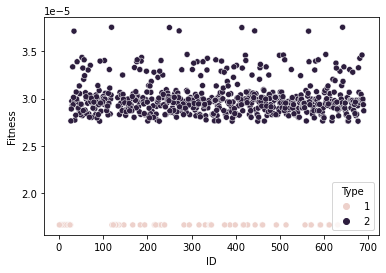

In [8]:
sns.scatterplot(x='ID',y='Fitness',hue='Type',data=df)

<AxesSubplot:xlabel='Distance_1', ylabel='Fitness'>

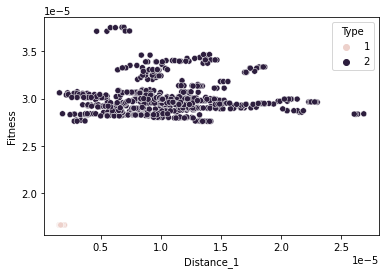

In [11]:
sns.scatterplot(x='Distance_1',y='Fitness',hue='Type',data=df)

<AxesSubplot:xlabel='Distance_1', ylabel='ID'>

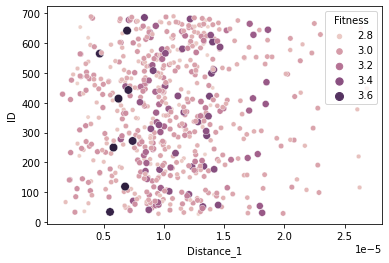

In [12]:
sns.scatterplot(x='Distance_1',y='ID',hue='Fitness',size='Fitness',data=df[df.Type==2])

<AxesSubplot:xlabel='Distance_1', ylabel='Fitness'>

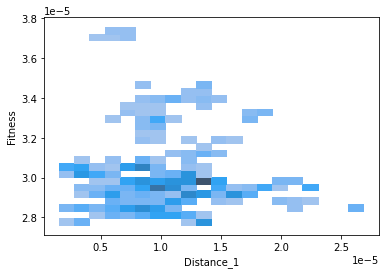

In [13]:
sns.histplot(x='Distance_1',y='Fitness',data=df[df.Type==2])

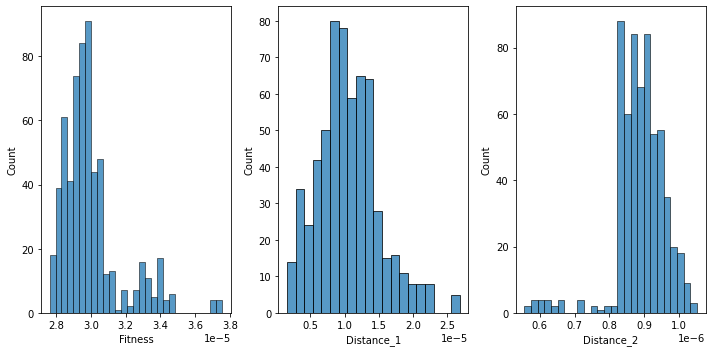

In [14]:
f, axes = plt.subplots(ncols=3,figsize=(10,5))
sns.histplot(x='Fitness',data=df[df.Type==2],ax=axes[0])
sns.histplot(x='Distance_1',data=df[df.Type==2],ax=axes[1])
sns.histplot(x='Distance_2',data=df[df.Type==2],ax=axes[2])
f.tight_layout()

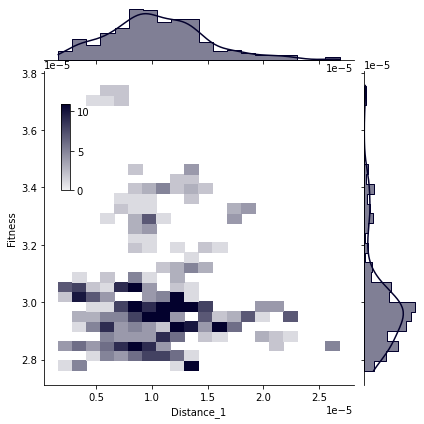

In [25]:
g = sns.JointGrid(data=df[df.Type==2], x="Distance_1", y="Fitness")
#g.ax_joint.set(yscale="log")
cax = g.fig.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sns.histplot, 
    cmap="light:#03012d", cbar=True, cbar_ax=cax,pmax=.8)
g.plot_marginals(sns.histplot, element="step", color="#03012d",kde=True)

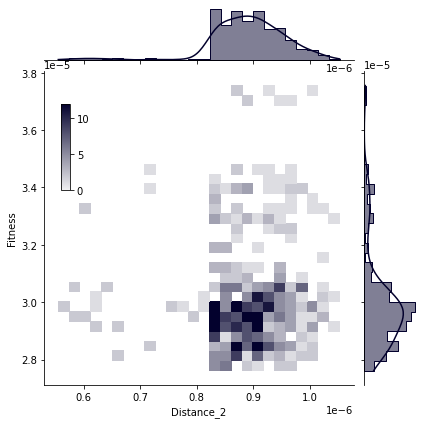

In [26]:
g = sns.JointGrid(data=df[df.Type==2], x="Distance_2", y="Fitness")
#g.ax_joint.set(yscale="log")
cax = g.fig.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sns.histplot, 
    cmap="light:#03012d", cbar=True, cbar_ax=cax,pmax=.8)
g.plot_marginals(sns.histplot, element="step", color="#03012d",kde=True)

<AxesSubplot:xlabel='Distance_1', ylabel='Distance_2'>

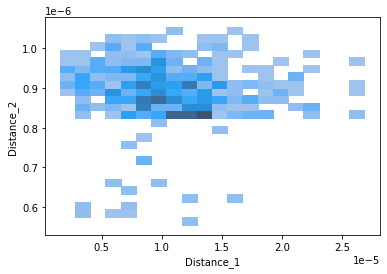

In [28]:
sns.histplot(x='Distance_1',y='Distance_2',data=df[df.Type==2])